# Unconditional Sampling (Weather)

This notebook mirrors the training setup and runs unconditional sampling, then plots results in the same cell.

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import xarray as xr

import deepassimilate as da

/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Using device: mps
Loaded checkpoint from: checkpoints/best_model.pth
Dataset shape: (365, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [220.80, 311.73] (original units)
std (observed values, normalized space): 0.4742721617221832
EDM-style scheduler detected. timesteps: 99 sigmas: 100
per-step sigmas (expected ~num_inference_steps): 50


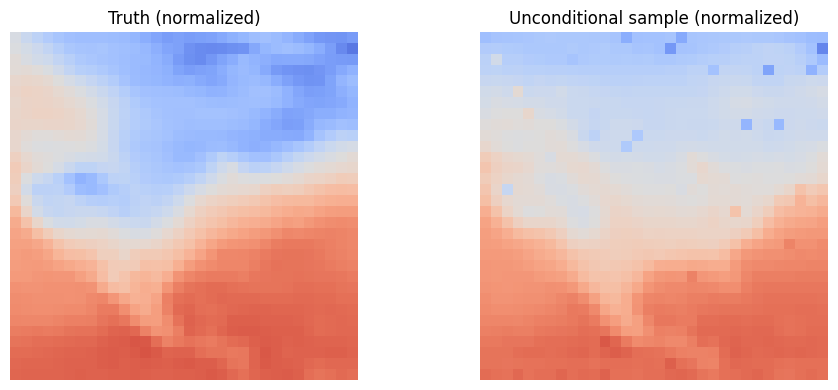

In [15]:
# --- Model, data, unconditional sampling + plot (single cell) ---
# Mirrors the training notebook config.

# Device
try:
    device = da.get_device()
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model & scheduler config (match training)
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")

architecture = "edm_unet_2d"   # or "basic_unet"
scheduler_name = "heun_edm"    # or "ddpm" / "ddim"
img_size = 32
channels = 1
num_train_timesteps = 1000
num_inference_steps = 50
guidance_scale = 2.0  # try 0.1, 0.5, 1.0, 2.0

# Build model + scheduler
model = da.build_unet_2d(
    architecture=architecture,
    img_size=img_size,
    in_channels=channels,
    out_channels=channels,
)
noise_scheduler = da.build_scheduler(
    name=scheduler_name,
    num_train_timesteps=num_train_timesteps,
)

# Load trained weights
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()
print(f"Loaded checkpoint from: {checkpoint_path}")

# Load one sample (same preprocessing as training)
data_dir = "data"
file_path = os.path.join(data_dir, "air.2m.gauss.2019.nc")
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Missing {file_path}. Download data or run the training notebook data cell first."
    )

lat_slice = slice(70, 10)
lon_slice = slice(235, 295)

ds_test = xr.open_dataset(file_path).sel(lat=lat_slice, lon=lon_slice)
train_dataset = da.WeatherDataset(ds_test.air)

sample = train_dataset[0]  # [C, H, W]
data_min, data_max = train_dataset.normalize_params

# Normalize to [-1, 1]
sample = sample * 2.0 - 1.0
x0 = sample.unsqueeze(0).to(device)


# --- 5% observation mask (NaNs for missing) ---
obs_fraction = 0.05
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

# observed entries only (ignore NaNs)
obs = x0_mask[mask]  # 1D tensor of observed values

std = obs.std(unbiased=False).item()
print("std (observed values, normalized space):", std)
gamma = 0.001   # good default
# Unconditional sampling
noise_scheduler.set_timesteps(num_inference_steps, device=device)

if hasattr(noise_scheduler, "sigmas"):
    sigma_t = noise_scheduler.sigmas.to(device)
    mu_t = torch.ones_like(sigma_t)
    print(
        "EDM-style scheduler detected. timesteps:", len(noise_scheduler.timesteps),
        "sigmas:", len(sigma_t)
    )
    # Heun uses 2nd-order updates -> timesteps ~= 2*steps-1, sigmas ~= 2*steps
    sigma_step = sigma_t[::2]  # one sigma per requested inference step
    print("per-step sigmas (expected ~num_inference_steps):", len(sigma_step))
else:
    # DDPM/DDIM-style
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
    mu_t = torch.sqrt(alphas_cumprod)
    sigma_t = torch.sqrt(1.0 - alphas_cumprod)
    print(
        "DDPM/DDIM-style scheduler. timesteps:", len(noise_scheduler.timesteps),
        "mu/sigma:", len(mu_t)
    )


# samples = torch.randn_like(x0)
samples = torch.randn_like(x0, requires_grad=True)
for i_t,t in enumerate(noise_scheduler.timesteps):
    # with torch.no_grad():
    # Stabilize inputs (match training clamp)
    samples = torch.nan_to_num(samples, nan=0.0, posinf=3.0, neginf=-3.0)
    samples = torch.clamp(samples, min=-3.0, max=3.0)

    t_batch = t.expand(samples.shape[0])
    noise_pred = model(samples, t_batch).sample
    noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

    samples = noise_scheduler.step(noise_pred, t, samples).prev_sample
    err = samples - x0_mask
    var = std**2 + gamma * (sigma_t[i_t] / mu_t[i_t]) ** 2


    valid = ~torch.isnan(err)
    err_valid = err[valid]

    # var can be scalar or tensor; use scalar here and keep it finite
    var_scalar = var if torch.is_tensor(var) else torch.tensor(var, device=err.device)

    log_p = -(err_valid**2 / var_scalar).sum() / 2
    s, = torch.autograd.grad(log_p, samples)
    samples = samples + sigma_t[i_t] * s
    #samples = samples + guidance_scale * (sigma_t[i_t] ** 2) * s
        

uncond_sample = samples[0].detach().cpu()
truth = x0[0].detach().cpu()

# Denormalize to original units
truth_dn = (truth + 1.0) / 2.0
truth_dn = truth_dn * (data_max - data_min) + data_min

uncond_dn = (uncond_sample + 1.0) / 2.0
uncond_dn = uncond_dn * (data_max - data_min) + data_min

# Normalize for visualization to [0, 1]
truth_vis = (truth_dn - data_min) / (data_max - data_min + 1e-8)
uncond_vis = (uncond_dn - data_min) / (data_max - data_min + 1e-8)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(truth_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[0].set_title("Truth (normalized)")
axs[0].axis("off")

axs[1].imshow(uncond_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[1].set_title("Unconditional sample (normalized)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

Using device: mps
Loaded checkpoint from: checkpoints/best_model.pth
Dataset shape: (365, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [220.80, 311.73] (original units)
std (observed values, normalized space): 0.46258029341697693
EDM-style scheduler detected. timesteps: 99 sigmas: 100
per-step sigmas (expected ~num_inference_steps): 50


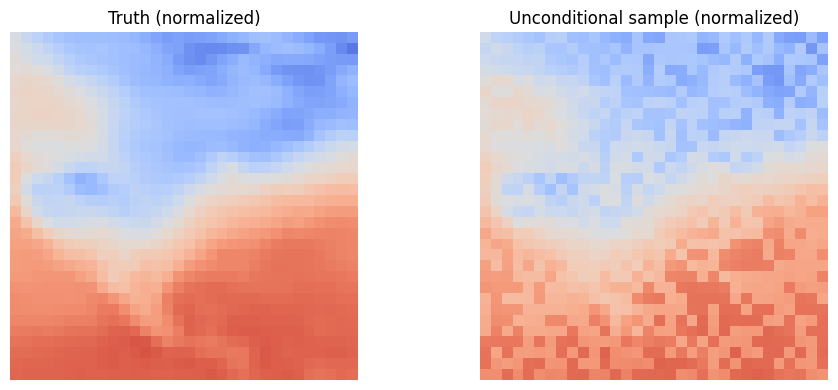

In [ ]:
# --- Model, data, unconditional sampling + plot (single cell) ---
# Mirrors the training notebook config.

# Device
try:
    device = da.get_device()
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model & scheduler config (match training)
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")

architecture = "edm_unet_2d"   # or "basic_unet"
scheduler_name = "heun_edm"    # or "ddpm" / "ddim"
img_size = 32
channels = 1
num_train_timesteps = 1000
num_inference_steps = 50
guidance_scale = 2.0  # try 0.1, 0.5, 1.0, 2.0

# Build model + scheduler
model = da.build_unet_2d(
    architecture=architecture,
    img_size=img_size,
    in_channels=channels,
    out_channels=channels,
)
noise_scheduler = da.build_scheduler(
    name=scheduler_name,
    num_train_timesteps=num_train_timesteps,
)

# Load trained weights
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()
print(f"Loaded checkpoint from: {checkpoint_path}")

# Load one sample (same preprocessing as training)
data_dir = "data"
file_path = os.path.join(data_dir, "air.2m.gauss.2019.nc")
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Missing {file_path}. Download data or run the training notebook data cell first."
    )

lat_slice = slice(70, 10)
lon_slice = slice(235, 295)

ds_test = xr.open_dataset(file_path).sel(lat=lat_slice, lon=lon_slice)
train_dataset = da.WeatherDataset(ds_test.air)

sample = train_dataset[0]  # [C, H, W]
data_min, data_max = train_dataset.normalize_params

# Normalize to [-1, 1]
sample = sample * 2.0 - 1.0
x0 = sample.unsqueeze(0).to(device)


# --- 5% observation mask (NaNs for missing) ---
obs_fraction = 0.5
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

# observed entries only (ignore NaNs)
obs = x0_mask[mask]  # 1D tensor of observed values

std = obs.std(unbiased=False).item()
print("std (observed values, normalized space):", std)
# gamma = 1e-3   # good default
# Unconditional sampling
noise_scheduler.set_timesteps(num_inference_steps, device=device)

if hasattr(noise_scheduler, "sigmas"):
    sigma_t = noise_scheduler.sigmas.to(device)
    mu_t = torch.ones_like(sigma_t)
    print(
        "EDM-style scheduler detected. timesteps:", len(noise_scheduler.timesteps),
        "sigmas:", len(sigma_t)
    )
    # Heun uses 2nd-order updates -> timesteps ~= 2*steps-1, sigmas ~= 2*steps
    sigma_step = sigma_t[::2]  # one sigma per requested inference step
    print("per-step sigmas (expected ~num_inference_steps):", len(sigma_step))
else:
    # DDPM/DDIM-style
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
    mu_t = torch.sqrt(alphas_cumprod)
    sigma_t = torch.sqrt(1.0 - alphas_cumprod)
    print(
        "DDPM/DDIM-style scheduler. timesteps:", len(noise_scheduler.timesteps),
        "mu/sigma:", len(mu_t)
    )


# samples = torch.randn_like(x0)
samples = torch.randn_like(x0, requires_grad=True)
for i_t,t in enumerate(noise_scheduler.timesteps):
    # with torch.no_grad():
    # Stabilize inputs (match training clamp)
    samples = torch.nan_to_num(samples, nan=0.0, posinf=3.0, neginf=-3.0)
    samples = torch.clamp(samples, min=-3.0, max=3.0)

    t_batch = t.expand(samples.shape[0])
    noise_pred = model(samples, t_batch).sample
    noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

    samples = noise_scheduler.step(noise_pred, t, samples).prev_sample
    err = samples - x0_mask
    var = std**2 + gamma * (sigma_t[i_t] / mu_t[i_t]) ** 2


    valid = ~torch.isnan(err)
    err_valid = err[valid]

    # var can be scalar or tensor; use scalar here and keep it finite
    var_scalar = var if torch.is_tensor(var) else torch.tensor(var, device=err.device)

    log_p = -(err_valid**2 / var_scalar).sum() / 2
    s, = torch.autograd.grad(log_p, samples)
    samples = samples + sigma_t[i_t] * s
    #samples = samples + guidance_scale * (sigma_t[i_t] ** 2) * s
        

uncond_sample = samples[0].detach().cpu()
truth = x0[0].detach().cpu()

# Denormalize to original units
truth_dn = (truth + 1.0) / 2.0
truth_dn = truth_dn * (data_max - data_min) + data_min

uncond_dn = (uncond_sample + 1.0) / 2.0
uncond_dn = uncond_dn * (data_max - data_min) + data_min

# Normalize for visualization to [0, 1]
truth_vis = (truth_dn - data_min) / (data_max - data_min + 1e-8)
uncond_vis = (uncond_dn - data_min) / (data_max - data_min + 1e-8)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(truth_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[0].set_title("Truth (normalized)")
axs[0].axis("off")

axs[1].imshow(uncond_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[1].set_title("Unconditional sample (normalized)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

Using device: mps
Loaded checkpoint from: checkpoints/best_model.pth
Dataset shape: (365, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [220.80, 311.73] (original units)
std_base (observed values, normalized space): 0.46351683139801025

--- Starting tuning over std_scale x gamma ---
NEW BEST: {'std': 0.11587920784950256, 'std_scale': 0.25, 'gamma': 1e-06, 'rmse': 16.707665761311848, 'corr': 0.635660727818807, 'score': 1.1518976833663501}
NEW BEST: {'std': 0.11587920784950256, 'std_scale': 0.25, 'gamma': 3.162277660168379e-06, 'rmse': 16.70766258239746, 'corr': 0.6356609265009562, 'score': 1.1518973348379684}
NEW BEST: {'std': 0.11587920784950256, 'std_scale': 0.25, 'gamma': 0.00031622776601683794, 'rmse': 16.63278579711914, 'corr': 0.6380749543507894, 'score': 1.1459537988634878}
NEW BEST: {'std': 0.11587920784950256, 'std_scale': 0.25, 'gamma': 0.001, 'rmse': 16.574325561523438, 'corr': 0.6429964105288187, 'score': 1.1382766704736123}
NEW BEST: {'std': 0.11587920784

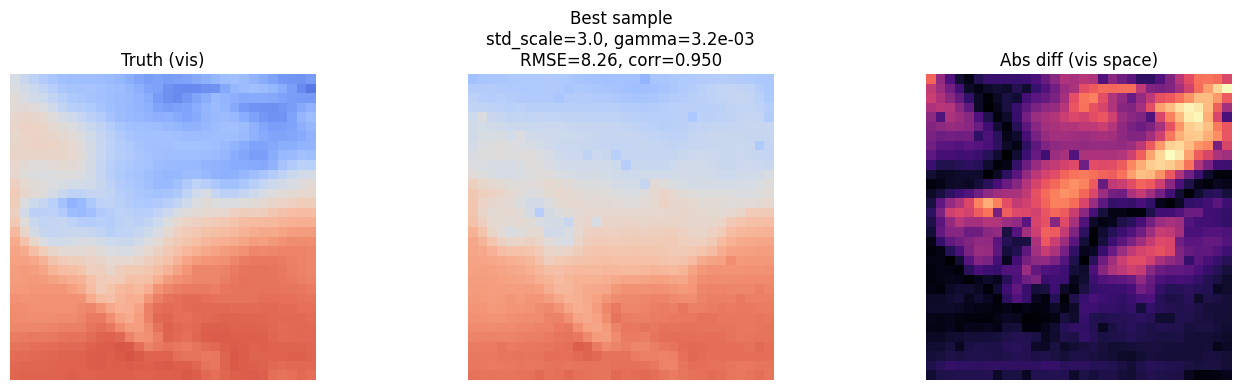

In [19]:
# --- COMPLETE: Model, data, sampling + tune std & gamma (Heun/EDM-safe) ---

import os
import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
try:
    device = da.get_device()
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# Model & scheduler config
# ----------------------------
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")

architecture = "edm_unet_2d"   # or "basic_unet"
scheduler_name = "heun_edm"    # or "ddpm" / "ddim"
img_size = 32
channels = 1
num_train_timesteps = 1000
num_inference_steps = 50

# ----------------------------
# Build model + scheduler
# ----------------------------
model = da.build_unet_2d(
    architecture=architecture,
    img_size=img_size,
    in_channels=channels,
    out_channels=channels,
)
noise_scheduler = da.build_scheduler(
    name=scheduler_name,
    num_train_timesteps=num_train_timesteps,
)

# ----------------------------
# Load trained weights
# ----------------------------
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()
print(f"Loaded checkpoint from: {checkpoint_path}")

# ----------------------------
# Load one sample
# ----------------------------
data_dir = "data"
file_path = os.path.join(data_dir, "air.2m.gauss.2019.nc")
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Missing {file_path}. Download data or run the training notebook data cell first."
    )

lat_slice = slice(70, 10)
lon_slice = slice(235, 295)

ds_test = xr.open_dataset(file_path).sel(lat=lat_slice, lon=lon_slice)
train_dataset = da.WeatherDataset(ds_test.air)

sample = train_dataset[0]  # [C,H,W] in [0,1]
data_min, data_max = train_dataset.normalize_params

# Normalize to [-1, 1]
sample = sample * 2.0 - 1.0
x0 = sample.unsqueeze(0).to(device)  # [1,C,H,W]

# ----------------------------
# Mask observations (NaNs for missing)
# ----------------------------
obs_fraction = 0.05
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

obs = x0_mask[mask]
std_base = obs.std(unbiased=False).item()
print("std_base (observed values, normalized space):", std_base)

# ----------------------------
# Metrics
# ----------------------------
def rmse(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2)).item()

def pearson_corr(a, b, eps=1e-8):
    a = a.flatten()
    b = b.flatten()
    a = a - a.mean()
    b = b - b.mean()
    denom = (torch.sqrt((a*a).mean()) * torch.sqrt((b*b).mean()) + eps)
    return ((a*b).mean() / denom).item()

# Truth in original units for scoring
truth = x0[0, 0].detach().cpu()  # [-1,1]
truth_dn = (truth + 1.0) / 2.0
truth_dn = truth_dn * (data_max - data_min) + data_min
truth_dn_t = truth_dn.to(device)
truth_std_dn = torch.std(truth_dn_t).item()

# ----------------------------
# Heun/EDM-safe scheduler reset
# ----------------------------
def reset_scheduler(sched):
    # Reinitialize timesteps every run (this is key)
    sched.set_timesteps(num_inference_steps, device=device)

    # Reset common private fields across diffusers versions
    for attr in ["_step_index", "_begin_index", "_init_noise_sigma", "_timesteps"]:
        if hasattr(sched, attr):
            try:
                setattr(sched, attr, None)
            except Exception:
                pass  # some may be read-only too; ignore safely

    # Some schedulers store state flags
    for attr in ["state_in_first_order", "_state_in_first_order"]:
        if hasattr(sched, attr):
            try:
                setattr(sched, attr, True)
            except Exception:
                pass

# ----------------------------
# Sampling function with tunable std & gamma
# (keeps your update: samples = samples + sigma_t[i] * s)
# ----------------------------
@torch.no_grad()
def run_with_params(std_used, gamma_used, seed=0, clamp_val=3.0):
    reset_scheduler(noise_scheduler)

    # After reset, capture the sigma/mu arrays for THIS run
    if hasattr(noise_scheduler, "sigmas"):
        sigma_arr = noise_scheduler.sigmas.to(device)
        mu_arr = torch.ones_like(sigma_arr)
    else:
        alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
        mu_arr = torch.sqrt(alphas_cumprod)
        sigma_arr = torch.sqrt(1.0 - alphas_cumprod)

    # seed (portable)
    torch.manual_seed(int(seed))
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(int(seed))

    samples = torch.randn_like(x0)

    def idx_safe(i, arr):
        return min(max(i, 0), arr.shape[0] - 1)

    # IMPORTANT for Heun: step() consumes internal index; do NOT assume i_t matches it.
    # We still use i_t for sigma/mu only, but clamp it.
    for i_t, t in enumerate(noise_scheduler.timesteps):
        samples = torch.nan_to_num(samples, nan=0.0, posinf=clamp_val, neginf=-clamp_val)
        samples = torch.clamp(samples, min=-clamp_val, max=clamp_val)

        t_batch = t.expand(samples.shape[0])
        noise_pred = model(samples, t_batch).sample
        noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

        samples = noise_scheduler.step(noise_pred, t, samples).prev_sample

        ii = idx_safe(i_t, sigma_arr)
        sig = sigma_arr[ii]
        mu = mu_arr[ii]

        with torch.enable_grad():
            samples_g = samples.detach().requires_grad_(True)

            err = samples_g - x0_mask
            valid = ~torch.isnan(err)
            err_valid = err[valid]

            var = (std_used ** 2) + gamma_used * (sig / mu) ** 2
            var = torch.clamp(var, min=1e-12)

            log_p = -(err_valid**2 / var).sum() / 2.0
            (s,) = torch.autograd.grad(log_p, samples_g)

        samples = samples + sig * s

    return samples[0, 0].detach().cpu()

# ----------------------------
# Tuning grid: std and gamma ONLY
# ----------------------------
std_scales = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0])
gammas = np.logspace(-6, -1, 11)  # 1e-6 ... 1e-1

seeds = [0, 1, 2]  # set to [0] to go faster

best = None
print("\n--- Starting tuning over std_scale x gamma ---")

for sscale in std_scales:
    std_used = float(std_base * sscale)
    for gamma_used in gammas:
        rmses, cors = [], []
        for sd in seeds:
            samp = run_with_params(std_used=std_used, gamma_used=float(gamma_used), seed=int(sd))

            # denorm sample to original units
            samp_dn = (samp + 1.0) / 2.0
            samp_dn = samp_dn * (data_max - data_min) + data_min
            samp_dn_t = samp_dn.to(device)

            r = rmse(samp_dn_t, truth_dn_t)
            c = pearson_corr(samp_dn_t, truth_dn_t)
            rmses.append(r)
            cors.append(c)

        rm = float(np.mean(rmses))
        cr = float(np.mean(cors))

        # combined score: normalized rmse + (1-corr)
        score = (rm / (truth_std_dn + 1e-12)) + (1.0 - cr)

        row = dict(
            std=float(std_used),
            std_scale=float(sscale),
            gamma=float(gamma_used),
            rmse=rm,
            corr=cr,
            score=float(score),
        )

        if best is None or row["score"] < best["score"]:
            best = row
            print("NEW BEST:", best)

print("\n=== BEST FOUND ===")
print(best)

# ----------------------------
# Plot best
# ----------------------------
best_sample = run_with_params(std_used=best["std"], gamma_used=best["gamma"], seed=0)

best_dn = (best_sample + 1.0) / 2.0
best_dn = best_dn * (data_max - data_min) + data_min

truth_vis = ((truth_dn - data_min) / (data_max - data_min + 1e-8)).numpy()
best_vis  = ((best_dn - data_min) / (data_max - data_min + 1e-8)).numpy()

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].imshow(truth_vis, cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[0].set_title("Truth (vis)")
axs[0].axis("off")

axs[1].imshow(best_vis, cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[1].set_title(
    f"Best sample\nstd_scale={best['std_scale']}, gamma={best['gamma']:.1e}\n"
    f"RMSE={best['rmse']:.3g}, corr={best['corr']:.3f}"
)
axs[1].axis("off")

axs[2].imshow(np.abs(best_vis - truth_vis), cmap="magma")
axs[2].set_title("Abs diff (vis space)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


Using device: mps
Loaded checkpoint from: checkpoints/best_model.pth
Dataset shape: (365, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [220.80, 311.73] (original units)
std (observed values, normalized space): 1.3905504941940308
EDM-style scheduler detected. timesteps: 99 sigmas: 100
per-step sigmas (expected ~num_inference_steps): 50


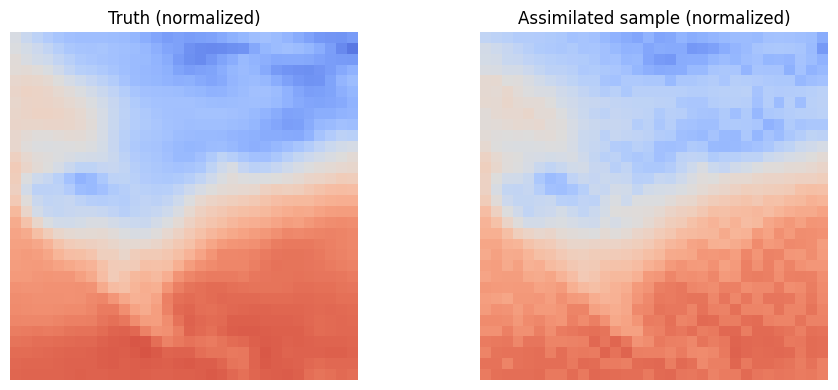

In [22]:
std = 1.3905504941940308
gamma = 0.0031622776601683794

# --- Model, data, unconditional sampling + plot (single cell) ---
# Mirrors the training notebook config.

# Device
try:
    device = da.get_device()
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model & scheduler config (match training)
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")

architecture = "edm_unet_2d"   # or "basic_unet"
scheduler_name = "heun_edm"    # or "ddpm" / "ddim"
img_size = 32
channels = 1
num_train_timesteps = 1000
num_inference_steps = 50
guidance_scale = 2.0  # try 0.1, 0.5, 1.0, 2.0

# Build model + scheduler
model = da.build_unet_2d(
    architecture=architecture,
    img_size=img_size,
    in_channels=channels,
    out_channels=channels,
)
noise_scheduler = da.build_scheduler(
    name=scheduler_name,
    num_train_timesteps=num_train_timesteps,
)

# Load trained weights
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()
print(f"Loaded checkpoint from: {checkpoint_path}")

# Load one sample (same preprocessing as training)
data_dir = "data"
file_path = os.path.join(data_dir, "air.2m.gauss.2019.nc")
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Missing {file_path}. Download data or run the training notebook data cell first."
    )

lat_slice = slice(70, 10)
lon_slice = slice(235, 295)

ds_test = xr.open_dataset(file_path).sel(lat=lat_slice, lon=lon_slice)
train_dataset = da.WeatherDataset(ds_test.air)

sample = train_dataset[0]  # [C, H, W]
data_min, data_max = train_dataset.normalize_params

# Normalize to [-1, 1]
sample = sample * 2.0 - 1.0
x0 = sample.unsqueeze(0).to(device)


# --- 5% observation mask (NaNs for missing) ---
obs_fraction = 0.5
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

# observed entries only (ignore NaNs)
obs = x0_mask[mask]  # 1D tensor of observed values

# std = obs.std(unbiased=False).item()
print("std (observed values, normalized space):", std)
# gamma = 1e-3   # good default
# Unconditional sampling
noise_scheduler.set_timesteps(num_inference_steps, device=device)

if hasattr(noise_scheduler, "sigmas"):
    sigma_t = noise_scheduler.sigmas.to(device)
    mu_t = torch.ones_like(sigma_t)
    print(
        "EDM-style scheduler detected. timesteps:", len(noise_scheduler.timesteps),
        "sigmas:", len(sigma_t)
    )
    # Heun uses 2nd-order updates -> timesteps ~= 2*steps-1, sigmas ~= 2*steps
    sigma_step = sigma_t[::2]  # one sigma per requested inference step
    print("per-step sigmas (expected ~num_inference_steps):", len(sigma_step))
else:
    # DDPM/DDIM-style
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
    mu_t = torch.sqrt(alphas_cumprod)
    sigma_t = torch.sqrt(1.0 - alphas_cumprod)
    print(
        "DDPM/DDIM-style scheduler. timesteps:", len(noise_scheduler.timesteps),
        "mu/sigma:", len(mu_t)
    )


# samples = torch.randn_like(x0)
samples = torch.randn_like(x0, requires_grad=True)
for i_t,t in enumerate(noise_scheduler.timesteps):
    # with torch.no_grad():
    # Stabilize inputs (match training clamp)
    samples = torch.nan_to_num(samples, nan=0.0, posinf=3.0, neginf=-3.0)
    samples = torch.clamp(samples, min=-3.0, max=3.0)

    t_batch = t.expand(samples.shape[0])
    noise_pred = model(samples, t_batch).sample
    noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

    samples = noise_scheduler.step(noise_pred, t, samples).prev_sample
    err = samples - x0_mask
    var = std**2 + gamma * (sigma_t[i_t] / mu_t[i_t]) ** 2


    valid = ~torch.isnan(err)
    err_valid = err[valid]

    # var can be scalar or tensor; use scalar here and keep it finite
    var_scalar = var if torch.is_tensor(var) else torch.tensor(var, device=err.device)

    log_p = -(err_valid**2 / var_scalar).sum() / 2
    s, = torch.autograd.grad(log_p, samples)
    samples = samples + sigma_t[i_t] * s
    #samples = samples + guidance_scale * (sigma_t[i_t] ** 2) * s
        

uncond_sample = samples[0].detach().cpu()
truth = x0[0].detach().cpu()

# Denormalize to original units
truth_dn = (truth + 1.0) / 2.0
truth_dn = truth_dn * (data_max - data_min) + data_min

uncond_dn = (uncond_sample + 1.0) / 2.0
uncond_dn = uncond_dn * (data_max - data_min) + data_min

# Normalize for visualization to [0, 1]
truth_vis = (truth_dn - data_min) / (data_max - data_min + 1e-8)
uncond_vis = (uncond_dn - data_min) / (data_max - data_min + 1e-8)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(truth_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[0].set_title("Truth (normalized)")
axs[0].axis("off")

axs[1].imshow(uncond_vis[0].numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[1].set_title("Assimilated sample (normalized)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Using device: mps
Loaded checkpoint from: checkpoints/best_model.pth
Dataset shape: (365, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [220.80, 311.73] (original units)
std (observed values, normalized space): 1.3905504941940308
EDM-style scheduler detected. timesteps: 99 sigmas: 100
per-step sigmas (expected ~num_inference_steps): 50


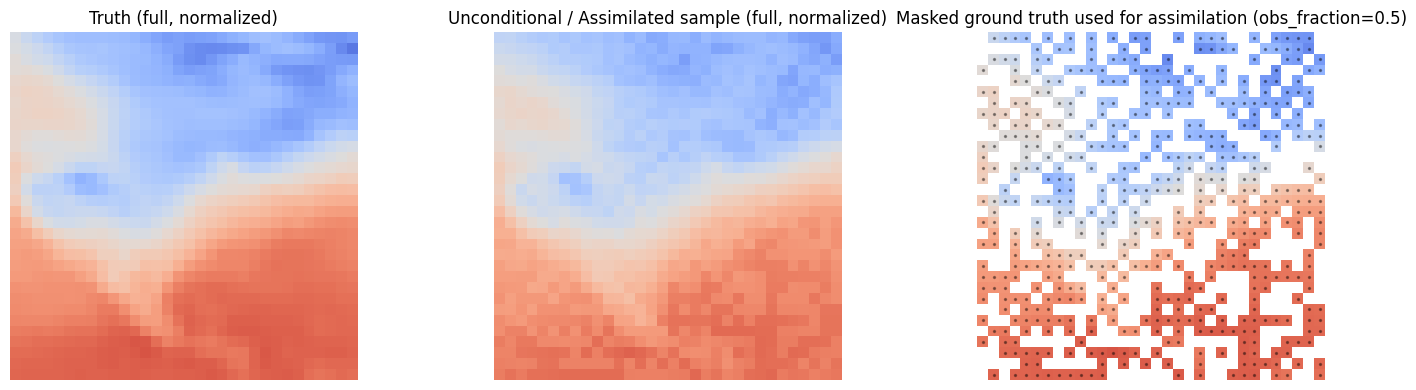

In [25]:
std = 1.3905504941940308
gamma = 0.0031622776601683794

# --- Model, data, unconditional sampling + plot (single cell) ---
# Mirrors the training notebook config.

# Device
try:
    device = da.get_device()
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model & scheduler config (match training)
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")

architecture = "edm_unet_2d"   # or "basic_unet"
scheduler_name = "heun_edm"    # or "ddpm" / "ddim"
img_size = 32
channels = 1
num_train_timesteps = 1000
num_inference_steps = 50
guidance_scale = 2.0  # try 0.1, 0.5, 1.0, 2.0

# Build model + scheduler
model = da.build_unet_2d(
    architecture=architecture,
    img_size=img_size,
    in_channels=channels,
    out_channels=channels,
)
noise_scheduler = da.build_scheduler(
    name=scheduler_name,
    num_train_timesteps=num_train_timesteps,
)

# Load trained weights
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()
print(f"Loaded checkpoint from: {checkpoint_path}")

# Load one sample (same preprocessing as training)
data_dir = "data"
file_path = os.path.join(data_dir, "air.2m.gauss.2019.nc")
if not os.path.exists(file_path):
    raise FileNotFoundError(
        f"Missing {file_path}. Download data or run the training notebook data cell first."
    )

lat_slice = slice(70, 10)
lon_slice = slice(235, 295)

ds_test = xr.open_dataset(file_path).sel(lat=lat_slice, lon=lon_slice)
train_dataset = da.WeatherDataset(ds_test.air)

sample = train_dataset[0]  # [C, H, W]
data_min, data_max = train_dataset.normalize_params

# Normalize to [-1, 1]
sample = sample * 2.0 - 1.0
x0 = sample.unsqueeze(0).to(device)


# --- 5% observation mask (NaNs for missing) ---
obs_fraction = 0.5
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

# observed entries only (ignore NaNs)
obs = x0_mask[mask]  # 1D tensor of observed values

# std = obs.std(unbiased=False).item()
print("std (observed values, normalized space):", std)
# gamma = 1e-3   # good default
# Unconditional sampling
noise_scheduler.set_timesteps(num_inference_steps, device=device)

if hasattr(noise_scheduler, "sigmas"):
    sigma_t = noise_scheduler.sigmas.to(device)
    mu_t = torch.ones_like(sigma_t)
    print(
        "EDM-style scheduler detected. timesteps:", len(noise_scheduler.timesteps),
        "sigmas:", len(sigma_t)
    )
    # Heun uses 2nd-order updates -> timesteps ~= 2*steps-1, sigmas ~= 2*steps
    sigma_step = sigma_t[::2]  # one sigma per requested inference step
    print("per-step sigmas (expected ~num_inference_steps):", len(sigma_step))
else:
    # DDPM/DDIM-style
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
    mu_t = torch.sqrt(alphas_cumprod)
    sigma_t = torch.sqrt(1.0 - alphas_cumprod)
    print(
        "DDPM/DDIM-style scheduler. timesteps:", len(noise_scheduler.timesteps),
        "mu/sigma:", len(mu_t)
    )


# samples = torch.randn_like(x0)
samples = torch.randn_like(x0, requires_grad=True)
for i_t,t in enumerate(noise_scheduler.timesteps):
    # with torch.no_grad():
    # Stabilize inputs (match training clamp)
    samples = torch.nan_to_num(samples, nan=0.0, posinf=3.0, neginf=-3.0)
    samples = torch.clamp(samples, min=-3.0, max=3.0)

    t_batch = t.expand(samples.shape[0])
    noise_pred = model(samples, t_batch).sample
    noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

    samples = noise_scheduler.step(noise_pred, t, samples).prev_sample
    err = samples - x0_mask
    var = std**2 + gamma * (sigma_t[i_t] / mu_t[i_t]) ** 2


    valid = ~torch.isnan(err)
    err_valid = err[valid]

    # var can be scalar or tensor; use scalar here and keep it finite
    var_scalar = var if torch.is_tensor(var) else torch.tensor(var, device=err.device)

    log_p = -(err_valid**2 / var_scalar).sum() / 2
    s, = torch.autograd.grad(log_p, samples)
    samples = samples + sigma_t[i_t] * s
    #samples = samples + guidance_scale * (sigma_t[i_t] ** 2) * s
        

uncond_sample = samples[0].detach().cpu()
truth = x0[0].detach().cpu()

# Denormalize to original units
truth_dn = (truth + 1.0) / 2.0
truth_dn = truth_dn * (data_max - data_min) + data_min

uncond_dn = (uncond_sample + 1.0) / 2.0
uncond_dn = uncond_dn * (data_max - data_min) + data_min

# Normalize for visualization to [0, 1]
truth_vis = (truth_dn - data_min) / (data_max - data_min + 1e-8)
uncond_vis = (uncond_dn - data_min) / (data_max - data_min + 1e-8)

# --- Make shapes consistent for masking/plotting ---
mask0 = mask[0].detach().cpu()  # [C,H,W] or [H,W]

# Take the first channel if mask has a channel dim
if mask0.ndim == 3:
    mask2d = mask0[0]           # [H,W]
else:
    mask2d = mask0              # [H,W]

# Your vis tensors might be [C,H,W] or [H,W]
uv = uncond_vis[0]              # could be [H,W] or [C,H,W]
tv = truth_vis[0]

if uv.ndim == 3:
    uncond2d = uv[0]            # [H,W]
else:
    uncond2d = uv               # [H,W]

if tv.ndim == 3:
    truth2d = tv[0]             # [H,W]
else:
    truth2d = tv                # [H,W]

# Apply mask: missing -> NaN
uncond_masked2d = uncond2d.clone()
uncond_masked2d[~mask2d] = float("nan")
# Normalize for visualization to [0, 1]
truth_vis = (truth_dn - data_min) / (data_max - data_min + 1e-8)
uncond_vis = (uncond_dn - data_min) / (data_max - data_min + 1e-8)

# ---- Build masked ground truth in *denormalized units* then convert to vis space ----
# x0_mask is in normalized-to-[-1,1] space with NaNs for missing.
x0_mask_cpu = x0_mask[0].detach().cpu()  # [C,H,W] or [H,W]

# Ensure 2D views for plotting
def to_2d(x):
    return x[0] if x.ndim == 3 else x

truth2d = to_2d(truth_vis)        # [H,W]
uncond2d = to_2d(uncond_vis)      # [H,W]

mask2d = to_2d(mask[0].detach().cpu()).bool()  # [H,W]

# Convert masked truth from [-1,1] -> original units -> [0,1] vis (keeping NaNs)
x0_mask_2d = to_2d(x0_mask_cpu)  # [H,W] with NaNs

masked_truth_dn = (x0_mask_2d + 1.0) / 2.0
masked_truth_dn = masked_truth_dn * (data_max - data_min) + data_min

masked_truth_vis = (masked_truth_dn - data_min) / (data_max - data_min + 1e-8)
# (NaNs remain NaNs)

# ---- Plot: Truth (full), Uncond/Assimilated (full), Masked GT observations ----
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(truth2d.numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[0].set_title("Truth (full, normalized)")
axs[0].axis("off")

axs[1].imshow(uncond2d.numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[1].set_title("Unconditional / Assimilated sample (full, normalized)")
axs[1].axis("off")

axs[2].imshow(masked_truth_vis.numpy(), cmap="coolwarm", vmin=0.0, vmax=1.0)
axs[2].set_title(f"Masked ground truth used for assimilation (obs_fraction={obs_fraction})")
axs[2].axis("off")

# Optional: make observation locations obvious (dots)
yy, xx = torch.where(mask2d)
axs[2].scatter(xx.numpy(), yy.numpy(), s=2, c="k", alpha=0.35)

plt.tight_layout()
plt.show()

In [3]:
# --- 5% observation mask (NaNs for missing) ---
obs_fraction = 0.05
mask = (torch.rand_like(x0) < obs_fraction).bool()

x0_mask = x0.clone()
x0_mask[~mask] = torch.nan

print("observed fraction:", mask.float().mean().item())
print("NaNs in x0_mask:", torch.isnan(x0_mask).sum().item())

observed fraction: 0.05078125
NaNs in x0_mask: 972


In [4]:
samples.shape

torch.Size([1, 1, 32, 32])

In [5]:
# --- mu(t) and sigma(t) from diffusers scheduler ---
# For EDM/Heun: x = x0 + sigma * eps  -> mu=1, sigma=sigmas
# For DDPM/DDIM: x_t = sqrt(alpha_cumprod) * x0 + sqrt(1-alpha_cumprod) * eps
num_inference_steps = 50
# Make sure inference steps are set explicitly
noise_scheduler.set_timesteps(num_inference_steps, device=device)

if hasattr(noise_scheduler, "sigmas"):
    sigma_t = noise_scheduler.sigmas.to(device)
    mu_t = torch.ones_like(sigma_t)
    print(
        "EDM-style scheduler detected. timesteps:", len(noise_scheduler.timesteps),
        "sigmas:", len(sigma_t)
    )
    # Heun uses 2nd-order updates -> timesteps ~= 2*steps-1, sigmas ~= 2*steps
    sigma_step = sigma_t[::2]  # one sigma per requested inference step
    print("per-step sigmas (expected ~num_inference_steps):", len(sigma_step))
else:
    # DDPM/DDIM-style
    alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
    mu_t = torch.sqrt(alphas_cumprod)
    sigma_t = torch.sqrt(1.0 - alphas_cumprod)
    print(
        "DDPM/DDIM-style scheduler. timesteps:", len(noise_scheduler.timesteps),
        "mu/sigma:", len(mu_t)
    )


EDM-style scheduler detected. timesteps: 99 sigmas: 100
per-step sigmas (expected ~num_inference_steps): 50


In [6]:
num_inference_steps

50

In [7]:
# --- Log-likelihood using only valid (non-NaN) observations ---
# log_p is reduced (sum) because it's a scalar log-likelihood over all observed points.

# err: difference at observed points (may contain NaNs)
valid = ~torch.isnan(err)
err_valid = err[valid]

# var can be scalar or tensor; use scalar here and keep it finite
var_scalar = var if torch.is_tensor(var) else torch.tensor(var, device=err.device)

log_p = -(err_valid**2 / var_scalar).sum() / 2
print("log_p:", log_p.item())

log_p: -0.32111743092536926


In [13]:
x0_mask.shape

torch.Size([1, 1, 32, 32])

In [18]:
torch.sum(torch.isnan(x0_mask))

tensor(978, device='mps:0')

In [16]:
torch.sum(torch.isnan(err))

tensor(978, device='mps:0')

In [17]:
err.shape

torch.Size([1, 1, 32, 32])

In [29]:
mu_t

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0')

In [30]:
sigma_t

tensor([25.1461, 22.2544, 22.2544, 19.7403, 19.7403, 17.5502, 17.5502, 15.6385,
        15.6385, 13.9664, 13.9664, 12.5010, 12.5010, 11.2140, 11.2140, 10.0814,
        10.0814,  9.0828,  9.0828,  8.2003,  8.2003,  7.4191,  7.4191,  6.7259,
         6.7259,  6.1096,  6.1096,  5.5605,  5.5605,  5.0702,  5.0702,  4.6315,
         4.6315,  4.2381,  4.2381,  3.8845,  3.8845,  3.5660,  3.5660,  3.2785,
         3.2785,  3.0182,  3.0182,  2.7822,  2.7822,  2.5675,  2.5675,  2.3718,
         2.3718,  2.1929,  2.1929,  2.0290,  2.0290,  1.8783,  1.8783,  1.7396,
         1.7396,  1.6113,  1.6113,  1.4925,  1.4925,  1.3821,  1.3821,  1.2791,
         1.2791,  1.1829,  1.1829,  1.0925,  1.0925,  1.0075,  1.0075,  0.9272,
         0.9272,  0.8511,  0.8511,  0.7787,  0.7787,  0.7095,  0.7095,  0.6431,
         0.6431,  0.5790,  0.5790,  0.5169,  0.5169,  0.4563,  0.4563,  0.3967,
         0.3967,  0.3374,  0.3374,  0.2773,  0.2773,  0.2146,  0.2146,  0.1443,
         0.1443,  0.0292,  0.0292,  0.00

In [32]:
noise_scheduler.timesteps.shape

torch.Size([99])

In [33]:
# observed entries only (ignore NaNs)
obs = x0_mask[mask]  # 1D tensor of observed values

std = obs.std(unbiased=False).item()
print("std (observed values, normalized space):", std)

std (observed values, normalized space): 0.5182493925094604


In [35]:
var = std**2 + gamma * (sigma_t[t] / mu_t[t]) ** 2

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [59]:
t

tensor(999., device='mps:0')

In [53]:
step_idx = int(np.float32(999.0))

In [55]:
sigma_t[step_idx]

IndexError: index 999 is out of bounds for dimension 0 with size 100

In [58]:
noise_scheduler.timesteps.shape

torch.Size([99])

In [74]:
torch.sum(s)

tensor(-15.4351, device='mps:0')

In [73]:
s

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.3013,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.2433],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.2649,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]],
       device='mps:0')